In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel
import matplotlib.pyplot as plt

In [3]:
device = 'cuda:1'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
print(model)

LitModel(
  (model): BeatGANsAutoencModel(
    (time_embed): TimeStyleSeperateEmbed(
      (time_embed): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): SiLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (style): Identity()
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (cond_emb_layers): Sequential(
          

In [5]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device)

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 

In [ ]:
print(cls_model.classifier)

Linear(in_features=512, out_features=40, bias=True)


In [ ]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[1]['img'][None]

In [ ]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.682391..10.663385].


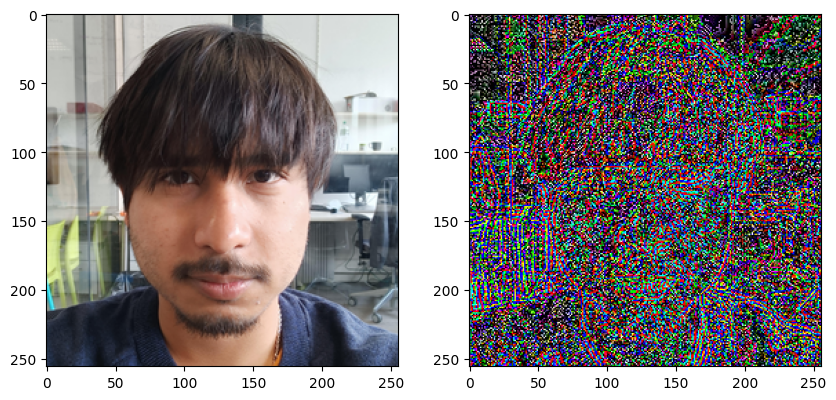

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [ ]:
print(CelebAttrDataset.id_to_cls)
print(len(CelebAttrDataset.id_to_cls))

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
40


In [ ]:
max_value = torch.max(cond)
min_value = torch.min(cond)

print("Maximum value in cond:", max_value.item())
print("Minimum value in cond:", min_value.item())

Maximum value in cond: 0.24517017602920532
Minimum value in cond: -1.6948184967041016


In [ ]:
cond_noramalized = cls_model.normalize(cond)

In [ ]:
cls_model.conds_mean.shape

torch.Size([1, 512])

In [ ]:
cls_model.conds_std.shape

torch.Size([1, 512])

In [ ]:
max_value = torch.max(cond_noramalized)
min_value = torch.min(cond_noramalized)

print("Maximum value in cond:", max_value.item())
print("Minimum value in cond:", min_value.item())

Maximum value in cond: 2.9366137981414795
Minimum value in cond: -2.838550567626953


In [ ]:
cls_id = CelebAttrDataset.cls_to_id['Male']

NameError: name 'CelebAttrDataset' is not defined

In [ ]:
magnitude = 0.4 #0 to 1

In [ ]:
cls_model.classifier.weight[cls_id][None, :].shape

torch.Size([1, 512])

In [ ]:
(magnitude * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)).shape

torch.Size([1, 512])

In [ ]:
cls_model.classifier.weight.shape

torch.Size([40, 512])

In [ ]:
cls_model.classifier.weight[cls_id].shape

torch.Size([512])

In [ ]:
cls_model.classifier.weight[cls_id][None, :].shape

torch.Size([1, 512])

In [ ]:
cls_model.classifier.weight[cls_id][None, :]

tensor([[ 8.4225e-02, -1.8765e-01,  6.5254e-02, -7.0497e-02, -3.3324e-01,
          1.9380e-01,  7.5453e-02,  5.5125e-02, -7.8334e-02, -6.4852e-02,
         -1.2995e-01, -2.0785e-01, -1.2908e-01,  3.5751e-01,  2.6553e-01,
         -1.3248e-01,  1.0735e-01, -1.4202e-01, -2.0470e-01,  1.2705e-01,
         -8.7771e-02,  2.5328e-01, -2.7924e-02, -5.2660e-02,  2.3685e-01,
         -2.0310e-01,  2.0310e-01,  1.0229e-01, -1.0974e-02,  3.9985e-02,
         -3.6820e-02,  4.4787e-02, -5.5240e-02,  1.2103e-02, -3.3025e-02,
         -5.0258e-02,  1.6283e-01, -2.7298e-01, -1.1517e-01,  1.4567e-01,
         -2.6097e-01,  8.5528e-02,  4.1622e-02,  8.8048e-02,  1.0405e-01,
         -1.2792e-01,  1.2176e-01,  2.2684e-02, -2.4673e-02, -8.1479e-02,
         -1.8173e-01,  1.6094e-01, -6.9903e-02,  1.3589e-01, -5.9794e-02,
          1.3180e-01, -2.2480e-01,  1.4607e-01, -2.6057e-01,  3.7376e-02,
         -2.9160e-01,  2.1669e-01,  2.0528e-02,  1.7759e-02, -4.4363e-02,
          3.4043e-03, -1.4592e-01, -2.

In [ ]:
cls_model.classifier.weight[cls_id][None, :].shape

torch.Size([1, 512])

In [ ]:
cls_model.classifier.weight[cls_id].shape

torch.Size([512])

In [ ]:
 F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1).shape

torch.Size([1, 512])

In [ ]:
cond2 = cls_model.normalize(cond)
cond2 = cond2 + magnitude * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)

In [ ]:
cond.shape

torch.Size([1, 512])

In [ ]:
cond.shape, cond2.shape

(torch.Size([1, 512]), torch.Size([1, 512]))

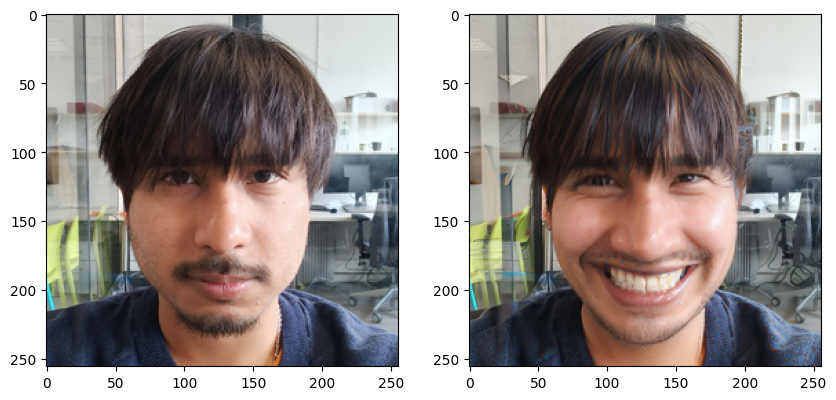

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

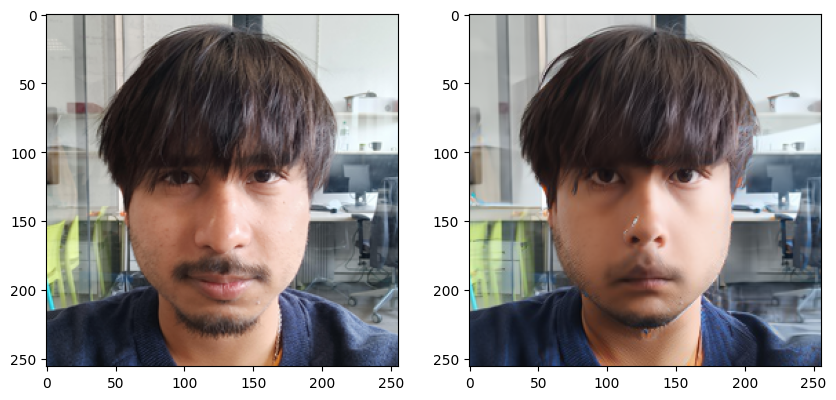

In [ ]:
cond2 = cls_model.normalize(cond)
cond2 = cond2 - magnitude * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')